# Test different metrics of surprise for framework paper

### set a measure of potential for inputs
 - for each road segment that is blocked calculate the potential as the capacity (lanes * speed)

In [4]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import json
import xml.etree.ElementTree as ET

In [5]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [8]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
#dbFile = 'lhc_samples/fleet_scenarios_conv1.db'
#dbFile = 'lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'
comb_scenarios = {}


In [9]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            comb_scenarios.update(result)    

print(len(comb_scenarios))

Length of rows:  2000
Length of rows:  2000
Length of rows:  2000
Length of rows:  0
Length of rows:  34
6034


In [41]:
### join 3 sqlite database files
#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'

dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFiles = [dbFile1, dbFile2, dbFile3]
comb_scenarios = {}
scenCount = 0
for dbFile in dbFiles:
    with ThreadPoolExecutor(max_workers=6) as executor:
        ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
        if 'fleet' in dbFile:
            for result in executor.map(read_fleet_from_db, queries):
                comb_scenarios.update(result)        
        else:
            for result in executor.map(read_ladris_from_db, queries):
                for key, value in result.items():
                    if key in comb_scenarios:
                        new_key = scenCount + int(key)
                        scenCount += 1
                        comb_scenarios[new_key] = value
                    else:
                        comb_scenarios[key] = value 
print(len(comb_scenarios))

Length of rows:  0
Length of rows:  34
Length of rows:  2000
Length of rows:  2000
Length of rows:  2000
Length of rows:  2000
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  292
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
9805


# Get Ladris Roads
- Potential is measured as Lanes * Speed * Length

In [42]:
roadFile = '../lhc_samples/data/ladris/C27F9DE4CE6780696685FB4A4E31E242_orig'
with open(roadFile, 'r') as f:
    data = json.load(f)

ladris_latlong_dict = {}
ladris_potential_dict = {}
modified_dict = {}

for i in data:
    #print(i)
    ladris_latlong_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['geometry']
    lanes = i['num_lanes']
    speed = i['speed_mph']
    ### convert speed to m/s
    speed = speed * 0.44704
    length = i['length_meters']
    ladris_potential_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = lanes * speed * length

In [43]:
ladris_latlong_dict[328123]

[[-121.1880419, 39.2519689],
 [-121.1879476, 39.2520865],
 [-121.1878389, 39.2522869],
 [-121.187756, 39.252606],
 [-121.1878234, 39.2528889],
 [-121.1878816, 39.2531086],
 [-121.1879835, 39.2533059],
 [-121.188129, 39.2534355],
 [-121.1882818, 39.2535031],
 [-121.1885147, 39.2535482],
 [-121.1887549, 39.2535257],
 [-121.1890532, 39.2534242],
 [-121.189257, 39.2532157],
 [-121.1893226, 39.2529208],
 [-121.1895626, 39.2526606]]

# Get Fleet Roads

In [44]:
### read segment id's from ../lhc_samples/data/fleet/segments.xml
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

fleet_segment_dict = {}
fleet_potential_dict = {}
for child in root:
    fleet_segment_dict[child.find('ID').text] = child.find('Link_ID').text
    lanes = int(child.find('Number_of_Lanes').text)
    speed = int(child.find('Freeflow_Speed').text)
    ### convert speed of mph to m/s
    speed = speed * 0.44704
    length = float(child.find('Length').text)
    ### convert length of miles to meters
    length = length * 1609.34
    fleet_potential_dict[child.find('ID').text] = lanes * speed

### read ../lhcsamples/data/fleet/links.xml
tree = ET.parse('../lhc_samples/data/fleet/links.xml')
root = tree.getroot()

fleet_link_dict = {}
for child in root:
    fleet_link_dict[child.find('ID').text] = [child.find('ANode').text, child.find('BNode').text]    

### read ../lhcsamples/data/fleet/nodes.xml and get lat long for BNode of each fleet_link_dict
tree = ET.parse('../lhc_samples/data/fleet/nodes.xml')
root = tree.getroot()

fleet_node_dict = {}
for child in root:
    fleet_node_dict[child.find('ID').text] = [child.find('Latitude').text, child.find('Longitude').text]

fleet_lat_long_dict = {}
### for each segment in fleet_segment_dict, get the link_id, from fleet_link_dict get the BNode, from fleet_node_dict get the lat long
for segment in fleet_segment_dict:
    link_id = fleet_segment_dict[segment]
    bnode = fleet_link_dict[link_id][1]
    lat_long = fleet_node_dict[bnode]
    fleet_lat_long_dict[segment] = [lat_long[1], lat_long[0]]

In [45]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [46]:
if 'ladris' in dbFile:
    df_results['minutes'] = df_results[0] * 60
    df_results['hours'] = df_results[0]
else:
    ### create a new column for the df_results called minutes that is equal to df_results[0] / 60
    df_results['minutes'] = df_results[0] / 60
    ### create a new column for df_results called hours that is equal to df_results[0] / 3600
    df_results['hours'] = df_results[0] / 3600

df_results.describe()

,0,minutes,hours
count,9805.000000,9805.000000,9805.000000
mean,16415.522693,273.592045,4.559867
std,5438.800093,90.646668,1.510778
min,9600.000000,160.000000,2.666667
25%,12900.000000,215.000000,3.583333
50%,13200.000000,220.000000,3.666667
75%,23400.000000,390.000000,6.500000
max,30000.000000,500.000000,8.333333


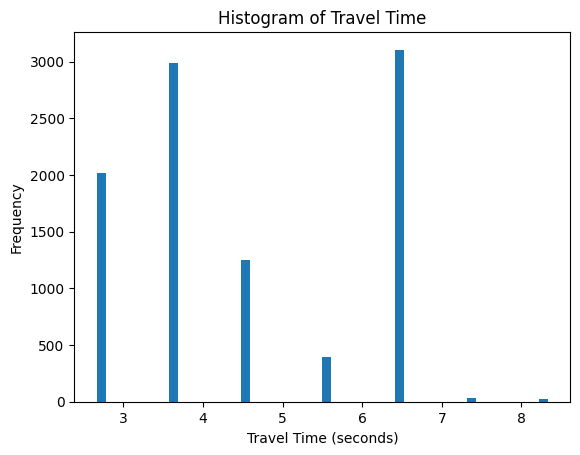

In [47]:
### Plot histogram of df_results
import matplotlib.pyplot as plt
plt.hist(df_results['hours'], bins=50)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()

In [48]:
df_results['hours']

0       4.583333
1       6.500000
2       3.666667
3       4.583333
4       6.500000
          ...   
9800    3.583333
9801    2.666667
9802    3.666667
9803    3.666667
9804    3.583333
Name: hours, Length: 9805, dtype: float64

In [49]:

### get indexs of df_results for df_results['hours'] >= 6.5
idx = df_results[df_results['hours'] >= 4].index
### get indexs of df_results for df_results['hours'] < 6.5
idx2 = df_results[df_results['hours'] < 4].index

### describe df_results for the indexs of idx
df_results.loc[idx].describe()

,0,minutes,hours
count,4800.000000,4800.000000,4800.000000
mean,21357.687500,355.961458,5.932691
std,3088.147131,51.469119,0.857819
min,16200.000000,270.000000,4.500000
25%,16500.000000,275.000000,4.583333
50%,23400.000000,390.000000,6.500000
75%,23400.000000,390.000000,6.500000
max,30000.000000,500.000000,8.333333


In [50]:
experiments = df
lowExperiments = experiments.loc[idx2]
highExperiments = experiments.loc[idx]
### Create outcomes as an array of df_results
outcomes = list(df_results['hours'].values)
lowOutcomes = list(df_results.loc[idx2]['hours'].values)
highOutcomes = list(df_results.loc[idx]['hours'].values)

In [51]:
### describe highOutcomes
pd.Series(highOutcomes).describe()

count    4800.000000
mean        5.932691
std         0.857819
min         4.500000
25%         4.583333
50%         6.500000
75%         6.500000
max         8.333333
dtype: float64

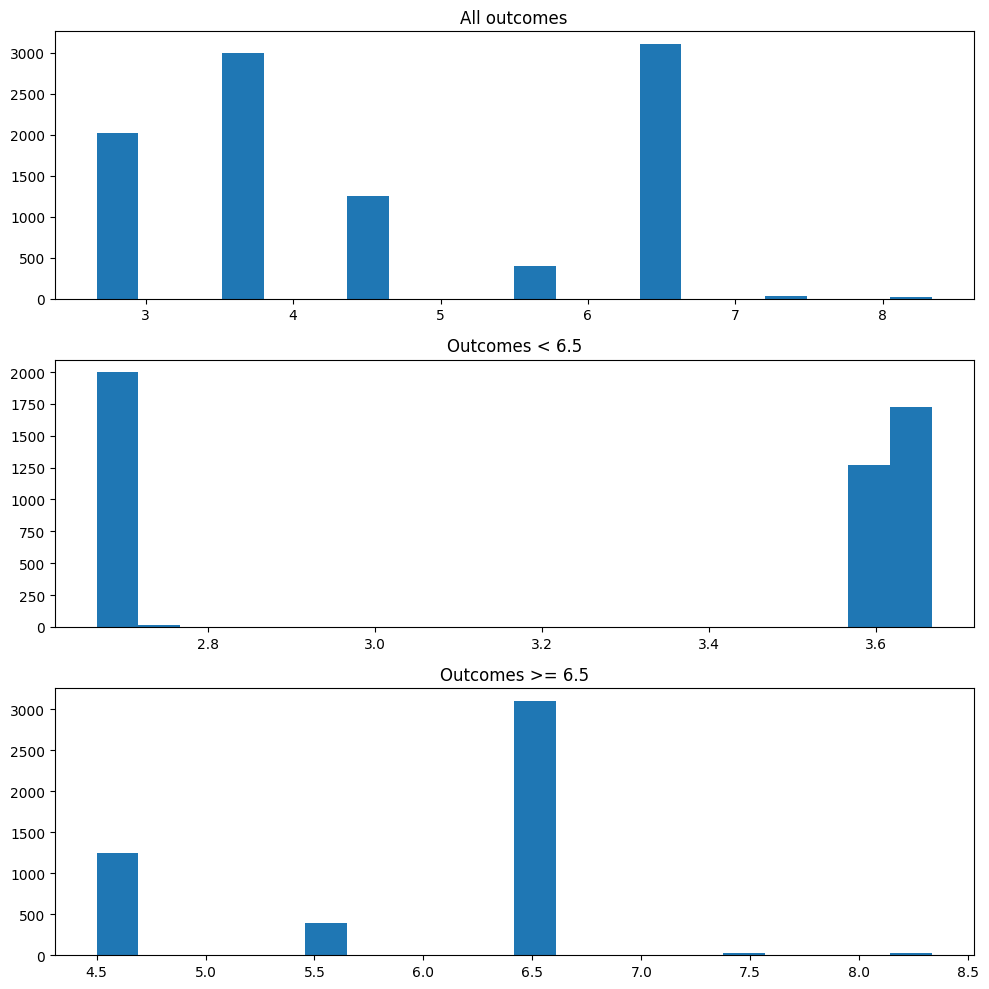

In [52]:
import matplotlib.pyplot as plt

### create three subplots of the outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(outcomes, bins=20)
ax[0].set_title('All outcomes')
ax[1].hist(lowOutcomes, bins=20)
ax[1].set_title('Outcomes < 6.5')
ax[2].hist(highOutcomes, bins=20)
ax[2].set_title('Outcomes >= 6.5')
plt.tight_layout()
plt.show()


# Defined High critical segments for LAdris

In [24]:
### ladris_hc is the high critical segments identified from clustering methods
ladris_hc = [334722, 329091, 334420, 329644, 330512, 330221,
       341386, 336153, 338651, 329174, 330184, 329821,
       329502, 344238, 332329, 335525, 341295, 334250,
       332253, 342952, 335197, 333480]

for i in ladris_hc:
    if ladris_potential_dict[i] < 68:
        print(i, ladris_potential_dict[i])


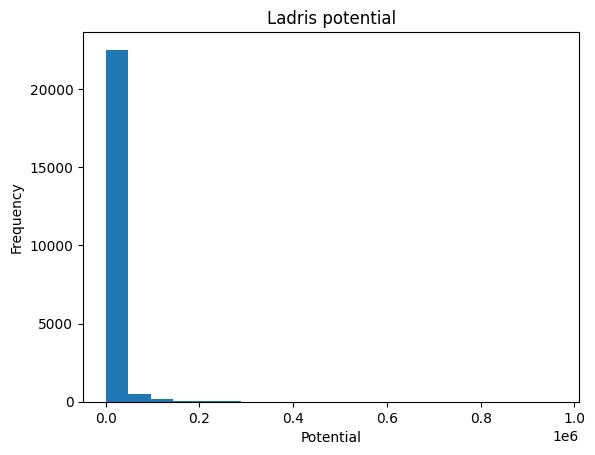

In [25]:
### print histogram of ladris_potential_dict
plt.hist(list(ladris_potential_dict.values()), bins=20)
plt.title('Ladris potential')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [26]:
### print df where columns are in ladris_hc
df.loc[:, ladris_hc].describe()

KeyError: "None of [Index([334722, 329091, 334420, 329644, 330512, 330221, 341386, 336153, 338651,\n       329174, 330184, 329821, 329502, 344238, 332329, 335525, 341295, 334250,\n       332253, 342952, 335197, 333480],\n      dtype='int64')] are in the [columns]"

In [65]:
### get all rows of df where columns defined in ladris_hc are 1
lad_hc_filtered_df = df.loc[:,ladris_hc]
lad_hc_filtered_df

,334722,329091,334420,329644,330512,330221,341386,336153,338651,329174,...,329502,344238,332329,335525,341295,334250,332253,342952,335197,333480
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,0,1,1,1,...,0,0,1,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,1,...,1,1,1,1,1,1,1,0,0,1
3,0,0,0,1,1,1,1,1,1,0,...,1,0,0,1,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
### how many segments have potential less than 50
count = 0
for i in ladris_potential_dict:
    if ladris_potential_dict[i] < 50:
        count += 1
### print the total number of segments with potential less than 50 and the total number of segments
print('Total number of segments with potential less than 50: ', count)
### print the total number of segments
print('Total number of segments: ', len(ladris_potential_dict))

Total number of segments with potential less than 50:  17140
Total number of segments:  23248


In [67]:
### get a list of all the segment keys in ladris_potential_dict that have values less than 50
low_potential_segments = []
for i in ladris_potential_dict:
    if ladris_potential_dict[i] < 400:
        low_potential_segments.append(i)
### print the number of segments in low_potential_segments
print('Number of segments with potential less than 25: ', len(low_potential_segments))

Number of segments with potential less than 25:  23248


In [68]:
lad_hc_filtered_df.columns

Index([334722, 329091, 334420, 329644, 330512, 330221, 341386, 336153, 338651,
       329174, 330184, 329821, 329502, 344238, 332329, 335525, 341295, 334250,
       332253, 342952, 335197, 333480],
      dtype='int64')

In [69]:
### how many segments in low_potential_segments are in lad_hc_filtered_df
count = 0
lp_evac = []
for i in low_potential_segments:
    if i in lad_hc_filtered_df.columns:
        count += 1
        if i not in lp_evac:
            lp_evac.append(i)
### print the number of segments in low_potential_segments that are in df.columns
print('Number of segments in low_potential_segments that are in df.columns: ', count)

Number of segments in low_potential_segments that are in df.columns:  22


In [70]:
### get rows of df[lp_evac] where any of the columns are 1
lp_evac_df = df.loc[:, lp_evac]

In [71]:
lp_evac_df

,329091,329174,329502,329644,329821,330184,330221,330512,332253,332329,...,334420,334722,335197,335525,336153,338651,341295,341386,342952,344238
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,0,1,...,1,0,0,1,1,1,0,0,1,0
2,0,1,1,1,1,1,0,0,1,1,...,1,0,0,1,1,0,1,1,0,1
3,0,0,1,1,0,0,1,1,0,0,...,0,0,1,1,1,1,1,1,0,0
4,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10991,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
### get all the rows of df where any of the columns in lp_evac are 1
#lp_evac_df = df[lp_evac]
### get the index of the lp_evac_df where any of the columns are 1
lp_evac_idx = lp_evac_df[lp_evac_df.any(axis=1)].index
### print the number of rows in lp_evac_df
print('Number of rows in lp_evac_df: ', len(lp_evac_df))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(df[df.any(axis=1)]))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(df[lp_evac_df.any(axis=1)]))


Number of rows in lp_evac_df:  10994
Number of rows in df where any of the columns in lp_evac are 1:  10969
Number of rows in df where any of the columns in lp_evac are 1:  7857


In [73]:
lp_evac_idx

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       10978, 10979, 10981, 10982, 10983, 10986, 10987, 10988, 10989, 10991],
      dtype='int64', length=7857)

In [74]:
### get the index of df_results where values are greater than 4
idx = df_results[df_results['hours'] > 4].index
hc_df = df.loc[idx]

### get the row index of hc_df where any of the columns in lp_evac are 1
hc_evac_idx = hc_df[hc_df.any(axis=1)].index
print(len(hc_evac_idx))


7634


In [75]:
hc_evac_idx

Index([    3,     7,     8,     9,    10,    13,    14,    15,    16,    19,
       ...
       10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992],
      dtype='int64', length=7634)

# Index Definitions
- lp_evacu_idx = index of rows that are low potential
- hc_evac_idx = index of rows that are high critical

In [27]:
### plot histogram of df_results.loc[hc_evac_idx]['hours'] and df_results.loc[lp_evac_idx]['hours']
plt.hist(df_results.loc[lp_evac_idx]['hours'], bins=20)
plt.hist(df_results.loc[hc_evac_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes')
plt.show()

NameError: name 'lp_evac_idx' is not defined

In [77]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
lp_hc_ladris_results_idx = df_results[df_results['hours'] > 4].index



In [78]:
len(lp_hc_ladris_results_idx)

7644

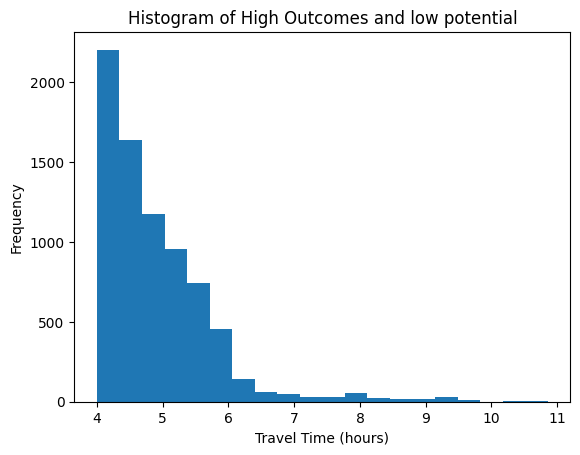

In [79]:
### plot histogram of df_results.loc[lp_hc_ladris_results_idx]['hours']
plt.hist(df_results.loc[lp_hc_ladris_results_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes and low potential')
plt.show()

In [80]:
### get the df_results where the index is in lp_hc_ladris_results_idx

In [53]:
### Plot a histogram of the potential of the segments in lp_evac
plt.hist([ladris_potential_dict[i] for i in lp_evac], bins=20)
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.title('Histogram of Low Potential Segments')
plt.show()

NameError: name 'lp_evac' is not defined

In [82]:
intersect_pot_crit = []
### print the potential of the segments in lp_evac that are less than 80
for i in lp_evac:
    if ladris_potential_dict[i] < 60:
        print(i, ladris_potential_dict[i])
        intersect_pot_crit.append(i)

330184 48
332253 48
333480 48
336153 48
341386 48
342952 48


In [83]:
### get rows of lp_evac_df where any of the columns are in intersect_pot_crit are 1 and are in lp_hc_ladris_results_idx

lp80_hc4_evac_df = lp_evac_df.loc[lp_hc_ladris_results_idx]
### get lp80_hc4_evac_df where any of the columns are in intersect_pot_crit are 1
lp80_hc4_evac_df = lp80_hc4_evac_df.loc[:, intersect_pot_crit]
### get the index of lp80_hc4_evac_df where any of the columns are 1
lp80_hc4_evac_idx = lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)].index

### print the number of rows in lp_evac_df
print('Number of rows in lp_evac_df: ', len(lp80_hc4_evac_df))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(lp_evac_df[lp_evac_df.any(axis=1)]))
### print the number of rows in df where any of the columns in lp_evac are 1
print('Number of rows in df where any of the columns in lp_evac are 1: ', len(lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)]))


Number of rows in lp_evac_df:  7644
Number of rows in df where any of the columns in lp_evac are 1:  7857
Number of rows in df where any of the columns in lp_evac are 1:  2625


Number of rows in lp80_hc4_evac_df:  2625


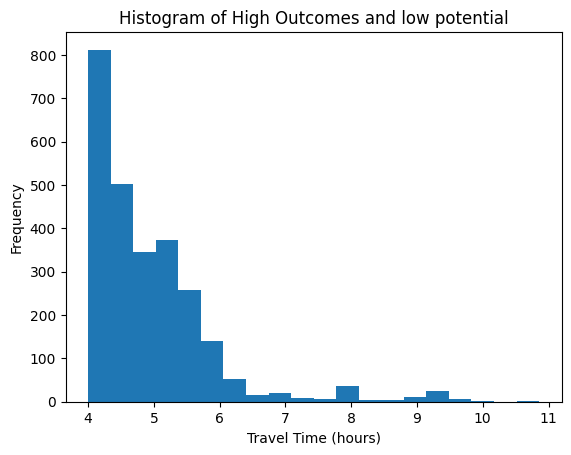

In [84]:
### lp_hc_ladris_results_idx
converged_idx = lp80_hc4_evac_df[lp80_hc4_evac_df.any(axis=1)].index
print('Number of rows in lp80_hc4_evac_df: ', len(converged_idx))
### plot histogram of df_results.loc[converged_idx]['hours']
plt.hist(df_results.loc[converged_idx]['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of High Outcomes and low potential')
plt.show()

# The list of segments that are associated with High critical evacuation times and are low on potential
## Critical Segments
![image.png](images/ladris_critical_segments.png)
## Critical and Low Potential
![image.png](images/lp80_hc4.png)


In [116]:
lp80_hc4_evac_df.loc[converged_idx]

,330184,332253,333480,336153,341386,342952
3,0,0,0,1,1,0
7,0,1,0,1,0,0
8,0,0,0,1,0,1
9,0,0,0,0,0,1
10,0,1,1,1,1,1
...,...,...,...,...,...,...
10970,0,0,1,0,0,0
10973,0,0,0,0,0,1
10977,0,0,0,0,1,0
10983,1,0,1,0,0,0


# Custom surprising critical measure
$$
Z=λ_1 × EvacuationTime − λ_2 × ScenarioPotential
$$
- Evacuation time is time 90% of population reaches destination
- Scenario Potential is the total potential measure of closed segments for that scenario

In [54]:
### create a new dataframe from df where each column is multiplied by the corresponding value in ladris_potential_dict
ladris_potential_df = df.copy()
for i in ladris_potential_dict:
    if i in ladris_potential_df.columns:
        ladris_potential_df[i] = ladris_potential_df[i] * ladris_potential_dict[i]

ladris_potential_df.head()

,24501202,105574370,10091169782,10091169911,10091170028,10091170033,116937342,708957455,10708960254,709015681,...,10949283531,708749840,105538093,711443267,10105593939,1156080189,1175163236,1175073250,11173056608,10105539843
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
### add a new column to ladris_potential_df that is the sum of all the columns
ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)

### create a new column in ladris_potential_df called 'count' that is the count of columns that are greater than 0
ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)

ladris_potential_df

,24501202,105574370,10091169782,10091169911,10091170028,10091170033,116937342,708957455,10708960254,709015681,...,105538093,711443267,10105593939,1156080189,1175163236,1175073250,11173056608,10105539843,sum,count
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,26,27
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,30
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,31
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,28,29
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,33,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,6
9801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,8
9802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,7
9803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,6


In [69]:
lam1 = 1.0
lam2 = 0.5

### create x as a normalized measure of df_results['hours'] to be values between 0 and 1
normEvac = (df_results['hours'] - df_results['hours'].min()) / (df_results['hours'].max() - df_results['hours'].min())

### creaet normPot as a normalized measure of ladris_potential_df['sum'] to be values between 0 and 1
normPot = (ladris_potential_df['sum'] - ladris_potential_df['sum'].min()) / (ladris_potential_df['sum'].max() - ladris_potential_df['sum'].min())

df_results['z'] = lam1*normEvac - lam2*normPot

df_results.head()


,0,minutes,hours,z
0,16500,275.0,4.583333,0.061640
1,23400,390.0,6.500000,0.367960
2,13200,220.0,3.666667,-0.142678
3,16500,275.0,4.583333,0.040363
4,23400,390.0,6.500000,0.325407


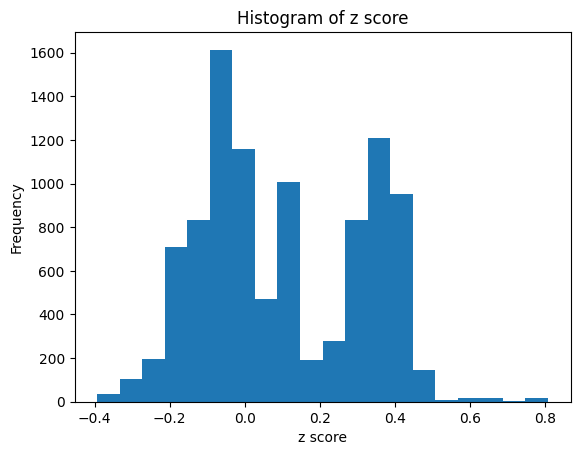

In [70]:
### Plot histogram of df_results['z']
plt.hist(df_results['z'], bins=20)
plt.xlabel('z score')
plt.ylabel('Frequency')
plt.title('Histogram of z score')
plt.show()

In [71]:
df_results['z'].describe()

count    9805.000000
mean        0.102503
std         0.215470
min        -0.393617
25%        -0.063830
50%         0.061640
75%         0.325407
max         0.808511
Name: z, dtype: float64

In [72]:
df.describe()

,24501202,105574370,10091169782,10091169911,10091170028,10091170033,116937342,708957455,10708960254,709015681,...,10949283531,708749840,105538093,711443267,10105593939,1156080189,1175163236,1175073250,11173056608,10105539843
count,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,...,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000,9805.000000
mean,0.030189,0.030903,0.030189,0.030087,0.030087,0.029577,0.030393,0.029373,0.029781,0.030189,...,0.029373,0.030189,0.031413,0.031107,0.029169,0.029373,0.126976,0.029475,0.029271,0.030393
std,0.171115,0.173063,0.171115,0.170835,0.170835,0.169425,0.171674,0.168858,0.169991,0.171115,...,0.168858,0.171115,0.174439,0.173615,0.168288,0.168858,0.332963,0.169142,0.168573,0.171674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Perform Prim Analysis on df_results and df based on maximizing z

TODO: perform this analysis on critical only and then on z (CSI)

In [73]:
import prim

In [78]:
### Get the index of rows in df_results['z'] that are greater than 0.1
idx = df_results[df_results['z'] > 0.1].index
### print the rows of df where the index is in idx
#df.loc[idx].describe()
df_results.loc[idx]['z'].describe()

count    4382.000000
mean        0.313667
std         0.112830
min         0.102003
25%         0.261577
50%         0.336045
75%         0.389237
max         0.808511
Name: z, dtype: float64

In [80]:
prim_alg = prim.Prim(df.loc[idx], df_results.loc[idx]['z'], threshold=0.3, threshold_type='>')
box = prim_alg.find_all()
print(len(box))

2


In [81]:
box[0].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,min,max,qp values
10091169783,0.0,0.0,NaN
10105539865,0.0,0.0,NaN
1155656409,0.0,0.0,NaN
999850560,0.0,0.0,NaN
10112051514,0.0,0.0,NaN
711443713,0.0,0.0,NaN
11173040617,0.0,0.0,NaN
10105593568,0.0,0.0,NaN
10105575910,0.0,0.0,NaN
1155656405,0.0,0.0,NaN


In [ ]:
### calculate information gain for each feature in df.loc[hc_evac_idx]
# Compute IG for all 200 features
#pot_info_gains = np.array([information_gain(df.loc[hc_evac_idx].to_numpy(), np.array(df.loc[hc_evac_idx], dtype=int), i) for i in range(df.loc[hc_evac_idx].to_numpy().shape[1])])
pot_info_gains = np.array([information_gain(df_hc_evac.to_numpy(), np.array(df_hc_eva_results['hours'], dtype=int), i) for i in range(df_hc_evac.to_numpy().shape[1])])

# Rank features by surprise (higher IG = more surprising)
pot_surprise_ranking = np.argsort(-pot_info_gains)

# Display top 10 surprising features
print("Top 10 surprising features based on entropy reduction:")
for i in pot_surprise_ranking[:10]:
    print(f"Feature {i}: Information Gain = {pot_info_gains[i]:.4f}")

In [ ]:
pot_surprise_ranking[:10]

In [ ]:
surprise_ranking[:10]

In [ ]:
### get the rows of df that have values of 1 for any of the columns in low_potential_segments
df[328559]

In [ ]:
### fleet potential
fleet_hc = ['10091170129', '10116945306', '10116970483', '711443713', '10105537445', '1173061709', '10112051514', '949301691', '10091169783']
for i in fleet_hc:
    if fleet_potential_dict[i] < 54:
        print(i, fleet_potential_dict[i])

In [ ]:
### plot histogram of fleet_potential_dict
plt.hist(list(fleet_potential_dict.values()), bins=20)
plt.title('Fleet potential')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.head()

In [ ]:
ladris_potential_df.loc[hc_evac_idx].head()

In [ ]:
### plot histogram of ladris_potential_df['sum']
plt.hist(ladris_potential_df['sum'], bins=20)
plt.title('Ladris potential sum')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.show()

In [ ]:
### get index values of all rows of ladris_potential_df['sum'] that are less than 4000
lowPotential_idx = ladris_potential_df[ladris_potential_df['sum'] < 4000].index


In [ ]:
### print ladris_potential_df for index values of lowPotential_idx
ladris_potential_df.loc[lowPotential_idx]

In [ ]:
ladris_potential_df.loc[lowPotential_idx]

In [ ]:
### get index values of all rows of ladris_potential_df.loc[lowPotential_idx] that have a 'count' greater than 0
lowPotential_idx2 = ladris_potential_df.loc[lowPotential_idx][ladris_potential_df['count'] > 0].index

ladris_potential_df.loc[lowPotential_idx2]

In [ ]:
### plot histogram of count for ladris_potential_df.loc[lowPotential_idx2]
plt.hist(ladris_potential_df.loc[lowPotential_idx2]['count'], bins=20)
plt.title('Ladris potential count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
### plot histogram of sum for ladris_potential_df.loc[lowPotential_idx2]
plt.hist(ladris_potential_df.loc[lowPotential_idx2]['sum'], bins=20)
plt.title('Ladris potential sum')
plt.xlabel('Sum')
plt.ylabel('Frequency')
plt.show()



In [ ]:
### create a new dataframe from ladris_potential_df.loc[lowPotential_idx2] with the sum and count removed
ladris_potential_df_low = ladris_potential_df.loc[lowPotential_idx2].drop(columns=['sum', 'count'])

ladris_potential_df_low


In [ ]:
import prim as prim
import numpy as np


In [ ]:
x = ladris_potential_df_low
y = ladris_potential_df.loc[lowPotential_idx2]['sum']

prim_alg = prim.Prim(x, y, threshold=2500, threshold_type='>')
box = prim_alg.find_box()
print(len(box.limits))

In [ ]:
box.limits

In [ ]:
box.limits.index

In [ ]:
df_results.head()

In [ ]:
### write df to csv and df_results as the last column titled evacuation_time
df['evacuation_time'] = df_results['hours']
### write df to csv
df.to_csv('ladris_df.csv', index=False)
### write df_results to csv
df_results.to_csv('ladris_df_results.csv', index=False)


In [ ]:
df.head()

In [ ]:
#for i in df.columns:
#    print(ladris_latlong_dict[i][0][0], ladris_latlong_dict[i][-1][1])

### generate csv file of ladris_latlong_dict based on the following columns
#road_id,start_x,start_y,end_x,end_y,capacity,road_type,zone
import csv
with open('ladris_latlong.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['road_id', 'start_x', 'start_y', 'end_x', 'end_y', 'capacity', 'road_type', 'zone'])
    for i in df.columns:
        if i != 'evacuation_time':
            #writeStr = i + ',' + str(ladris_latlong_dict[i][0][0]) + ',' + str(ladris_latlong_dict[i][0][1]) + ',' + str(ladris_latlong_dict[i][-1][0]) + ',' + str(ladris_latlong_dict[i][-1][1]) + ',local,unknown'        
            writer.writerow([i, ladris_latlong_dict[i][0][0], ladris_latlong_dict[i][0][1], ladris_latlong_dict[i][-1][0], ladris_latlong_dict[i][-1][1], 1, "local", "west"])        



In [ ]:
### identify the index values of df where box.limits.index values are set to 1
scen_roads = box.limits.index
### convert scen_roads to integers
scen_roads = [int(i) for i in scen_roads]
### get the index values of df where 3 or more columns in scen_roads are 1
index_3plus = []
for i in range(len(df)):
    if df.iloc[i][scen_roads].sum() >= 3:
        print(i)        
        index_3plus.append(i)

print(len(index_3plus))


In [ ]:
### print the colums of df.iloc[500][scen_roads] that are equal to 1
tempIDS = list(df.iloc[500][scen_roads][df.iloc[500][scen_roads] == 1].index)
### get all the index values of df where tempIDS are 1
tempIDS = [int(i) for i in tempIDS]
### get the index values of df where tempIDS are 1



In [ ]:
 ### create scenario_df.json from df where index is in index_3plus where each row is a distionary of the following structure:
#{
#        "scenario_id": 1,
#        "description": "Major arterial routes blocked",
#        "conditions": [
#            {
#                "road_id": "road_10",
#               "status": "closed"
#            },
#            {
#                "road_id": "road_25",
#                "status": "closed"
#            },
#            {
#                "road_id": "road_42",
#                "status": "closed"
#            }
#        ],
#        "avg_evacuation_time": 112.5,
#        "probability_high_impact": 0.87,
#        "coverage": 0.12
#    }
import json
import pandas as pd
import numpy as np
import csv
import random
import os
import math

scenarios = []
for index in index_3plus:
    # Create a dictionary for the scenario
    scenario = {
        "scenario_id": index,
        "description": "Major arterial routes blocked",
        "conditions": [],
        "avg_evacuation_time": df_results['hours'].iloc[index],
        "probability_high_impact": random.uniform(0.5, 1.0),  # Random value between 0.5 and 1.0
        "coverage": random.uniform(0.1, 0.5)  # Random value between 0.1 and 0.5
    }
    
    # Add conditions based on the columns in scen_roads
    for road in scen_roads:
        if df.iloc[index][road] == 1:
            condition = {
                "road_id": str(road),
                "status": "closed"
            }
            scenario["conditions"].append(condition)
    
    # Append the scenario to the list of scenarios
    scenarios.append(scenario)
# Write the scenarios to a JSON file
with open('scenario_df.json', 'w') as json_file:
    json.dump(scenarios, json_file, indent=4)

